##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Rock, Paper & Scissors with TensorFlow Hub - TFLite

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_lite/tflite_c05_exercise_rock_paper_scissors.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_lite/tflite_c05_exercise_rock_paper_scissors.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
</table>

## Setup

In [1]:
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Version:  2.5.0
Eager mode:  True
Hub version:  0.12.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


## Select the Hub/TF2 module to use

Hub modules for TF 1.x won't work here, please use one of the selections provided.

In [2]:
module_selection = ("mobilenet_v2", 224, 1280) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


## Data preprocessing

Use [TensorFlow Datasets](http://tensorflow.org/datasets) to load the rock, paper and scissors dataset.

This `tfds` package is the easiest way to load pre-defined data. If you have your own data, and are interested in importing using it with TensorFlow see [loading image data](../load_data/images.ipynb)


In [3]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

The `tfds.load` method downloads and caches the data, and returns a `tf.data.Dataset` object. These objects provide powerful, efficient methods for manipulating data and piping it into your model.

Since `"rock_paper_scissors"` doesn't define standard splits, use the subsplit feature to divide it into (train, validation, test) with 80%, 10%, 10% of the data respectively.

In [4]:
# splits = tfds.Split.ALL.subsplit(weighted=(80, 10, 10))

# Go to the TensorFlow Dataset's website and search for the Rock, Paper, Scissors dataset and load it here
splits, info = tfds.load("rock_paper_scissors", split = ['train[80%:]', 'train[80%:90%]', 'train[90%:]'], with_info=True, as_supervised=True)
    
# Save the dataset splits in a tuple
(train_examples, validation_examples, test_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteOHE5GP/rock_paper_scissors-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incompleteOHE5GP/rock_paper_scissors-test.tfrecord
Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


### Format the Data

Use the `tf.image` module to format the images for the task.

Resize the images to a fixes input size, and rescale the input channels

In [5]:
def format_image(image, label):
  image = tf.image.resize(image, IMAGE_SIZE) / 255.0
  return  image, label


Now shuffle and batch the data


In [6]:
BATCH_SIZE = 32 #@param {type:"integer"}

In [7]:
# Prepare the examples by preprocessing them and then batching them (and optionally prefetching them)

# If you wish you can shuffle train set here
train_batches = train_examples.shuffle(num_examples//4).batch(BATCH_SIZE).map(format_image).prefetch(1)

validation_batches = validation_examples.batch(BATCH_SIZE).map(format_image).prefetch(1)
test_batches = test_examples.batch(1).map(format_image)

Inspect a batch

In [8]:
for image_batch, label_batch in train_batches.take(1):
  pass

image_batch.shape

TensorShape([32, 224, 224, 3])

## Defining the model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [9]:
do_fine_tuning = True #@param {type:"boolean"}

In [10]:
# Build the model with a TFHub KerasLayer and attach a classification head to it
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE,
                   input_shape=IMAGE_SIZE + (3, ), 
                   output_shape=[FV_SIZE],
                   trainable=do_fine_tuning),
    tf.keras.layers.Dense(num_classes)
])
model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


## Training the model

In [11]:
if do_fine_tuning:
  model.compile(
    optimizer=tf.keras.optimizers.SGD(lr=0.002, momentum=0.9), 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])
else:
  model.compile(
    optimizer='adam', 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [12]:
EPOCHS = 3
hist = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/3
16/16 [==============================] - 36s 235ms/step - loss: 1.0285 - accuracy: 0.5139 - val_loss: 0.5968 - val_accuracy: 0.8810
Epoch 2/3
16/16 [==============================] - 3s 135ms/step - loss: 0.4231 - accuracy: 0.9325 - val_loss: 0.2750 - val_accuracy: 0.9841
Epoch 3/3
16/16 [==============================] - 3s 137ms/step - loss: 0.2220 - accuracy: 0.9861 - val_loss: 0.1719 - val_accuracy: 0.9881


## Export the model

In [13]:
RPS_SAVED_MODEL = "./exp_saved_model"

Export the SavedModel

In [14]:
# Use TensorFlow's SavedModel API to export the SavedModel from the trained Keras model
tf.saved_model.save(model, RPS_SAVED_MODEL)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.



FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.


INFO:tensorflow:Assets written to: ./exp_saved_model/assets


INFO:tensorflow:Assets written to: ./exp_saved_model/assets


Here you can verify the default signature of your exported SavedModel

In [15]:
%%bash -s $RPS_SAVED_MODEL
saved_model_cli show --dir $1 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_keras_layer_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 3)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


In [16]:
loaded = tf.saved_model.load(RPS_SAVED_MODEL)

In [17]:
print(list(loaded.signatures.keys()))
infer = loaded.signatures["serving_default"]
print(infer.structured_input_signature)
print(infer.structured_outputs)

['serving_default']
((), {'keras_layer_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_layer_input')})
{'dense': TensorSpec(shape=(None, 3), dtype=tf.float32, name='dense')}


## Convert with TFLiteConverter

In [18]:
# Intialize the TFLite converter to load the SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model(RPS_SAVED_MODEL)
# Set the optimization strategy for 'size' in the converter 
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]

def representative_dataset():
  for input, _ in test_batches.take(100):
    yield([tf.dtypes.cast(input, tf.float32)])

converter.representative_dataset = representative_dataset

# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# converter.inference_input_type = tf.int8  # or tf.uint8

# converter.inference_output_type = tf.int8  # or tf.uint8

tflite_model = converter.convert()
    
with open("converted_model.tflite", "wb") as f:
  f.write(tflite_model)

Run the following cells to check whether your TFLite model is working using the Python Interpreter

In [20]:
#@title Loading the converted TFLite model...
# Load TFLite model and allocate tensors.
tflite_model_file = 'converted_model.tflite'
with open(tflite_model_file, 'rb') as fid:
  tflite_model = fid.read()
  
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [23]:
#@title Testing on random test examples...
from tqdm import tqdm

# Gather results for the randomly sampled test images
predictions = []

test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(10)):
  interpreter.set_tensor(input_index, tf.dtypes.cast(img, tf.int8))
  interpreter.invoke()
  predictions.append(interpreter.get_tensor(output_index))
  
  test_labels.append(label.numpy()[0])
  test_imgs.append(img)

100%|██████████| 10/10 [00:10<00:00,  1.03s/it]


In [25]:
#@title Utility functions for plotting
# Utilities for plotting

class_names = ['rock', 'paper', 'scissors']

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
    
  img = np.squeeze(img)

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'green'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)


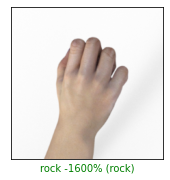

In [ ]:
#@title Visualize the outputs { run: "auto" }
index = 1 #@param {type:"slider", min:0, max:9, step:1}
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(index, predictions, test_labels, test_imgs)
plt.show()

Download the model

**NOTE: You might have to run to the cell below twice**

In [26]:
class_names = ['rock', 'paper', 'scissors']

with open('labels.txt', 'w') as f:
  f.write('\n'.join(class_names))


try:
  from google.colab import files
  files.download('converted_model.tflite')  
  files.download('labels.txt')
except:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Prepare the test images for download (Optional)

This part involves downloading additional test images for the Mobile Apps only in case you need to try out more samples

In [ ]:
!mkdir -p test_images

In [ ]:
from PIL import Image

for index, (image, label) in enumerate(test_batches.take(50)):
  image = tf.cast(image * 255.0, tf.uint8)
  image = tf.squeeze(image).numpy()
  pil_image = Image.fromarray(image)
  pil_image.save('test_images/{}_{}.jpg'.format(class_names[label[0]], index))

In [ ]:
!ls test_images

In [ ]:
!zip -qq rps_test_images.zip -r test_images/

In [ ]:
try:
  files.download('rps_test_images.zip')
except:
  pass